### Try it 10.1: Decomposing Time Series


<center>
    <img src = './images/spots.png' /><img src = './images/air.png' />
</center>


 

This activity fouses on exploring two different time series and the decomposed elements.  The example of sunspots data is given as well as a dataset containing air passenger information through the twentieth century in the United States.  These are both time series datasets however there is a distinct difference in the nature of the time series.  

Below, you are to use the statsmodels function `seasonal_decompose` to show how the trend and seasonality of the series differ in (perhaps) expected ways.  To begin, you are to make sure the datasets contain an appropriate time stamp index -- statsmodels expects this.  Then, use the `seasonal_decompose` function to decompose the series into trend and seasonality.  Examing plots of these elements, and discuss the similarities and differences between these components for the two time series.  

In [2]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Sunspots

In [4]:
sunspots = sm.datasets.sunspots.load_pandas().data
sunspots["YEAR"] = pd.to_datetime(sunspots["YEAR"], format="%Y")
sunspots = sunspots.set_index("YEAR")
sunspots

,SUNACTIVITY
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0
...,...
2004-01-01,40.4
2005-01-01,29.8
2006-01-01,15.2


In [9]:
y_hist = sunspots.loc["1900":"2000", "SUNACTIVITY"]

In [8]:
y_hist[0]

5.0

In [10]:
period_guess = 12
lows = [0]
next_low_guess = period_guess
search_width = 5

while next_low_guess <= len(y_hist):   
    low_best = next_low_guess
    min_val = np.inf

    for kw in range(-search_width, search_width + 1):
        kidx = next_low_guess + kw
        if kidx < len(y_hist):
            this_val = y_hist[kidx]
            if this_val < min_val:
                min_val = this_val
                low_best = kidx

    lows.append(low_best)
    next_low_guess = low_best + period_guess
    print("Added low at index %03d with value %5.2f, next guess = %03d" % (low_best, min_val, next_low_guess))

Added low at index 013 with value  1.40, next guess = 025
Added low at index 023 with value  5.80, next guess = 035
Added low at index 033 with value  5.70, next guess = 045
Added low at index 044 with value  9.60, next guess = 056
Added low at index 054 with value  4.40, next guess = 066
Added low at index 064 with value 10.20, next guess = 076
Added low at index 076 with value 12.60, next guess = 088
Added low at index 086 with value 13.40, next guess = 098
Added low at index 096 with value  8.60, next guess = 108


In [11]:
lows

[0, 13, 23, 33, 44, 54, 64, 76, 86, 96]

In [62]:
lows

[0, 13, 23, 33, 44, 54, 64, 76, 86, 96]

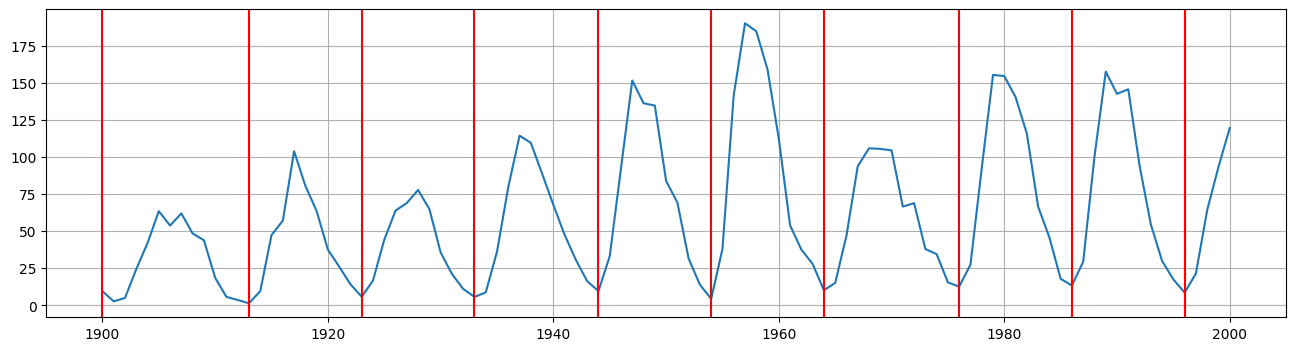

In [12]:
plt.figure(figsize=(16, 4))
plt.plot(y_hist)
for low in lows:
    if low < len(y_hist):
        plt.axvline(x=y_hist.index[low], color="red")
# plt.legend()
plt.show()


## Trend

In [15]:
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.seasonal import _extrapolate_trend

In [16]:
avg_period = int(np.round(np.mean(np.diff(np.array(lows)))))
filt = np.ones(avg_period + 1)
filt[0] = 0.5
filt[-1] = 0.5
filt /= avg_period
filt

array([0.04545455, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.04545455])

In [21]:
trend = convolution_filter(y_hist, filt)
trend = _extrapolate_trend(trend, len(filt)) # fails... why?

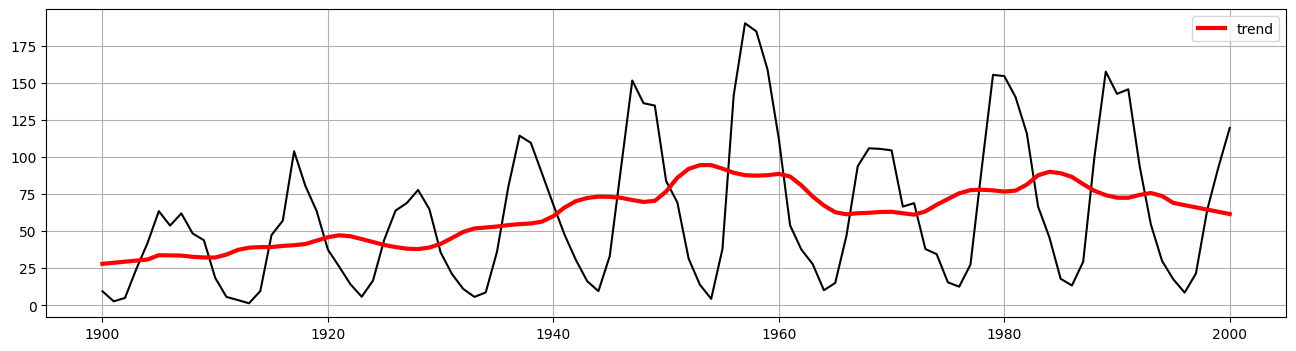

In [22]:
plt.figure(figsize=(16, 4))
plt.plot(y_hist, "k")
plt.plot(trend, "r", linewidth=3, label="trend")
plt.legend()
plt.show()

In [23]:
detrended = (y_hist - trend).to_numpy()

## Seasonal

# Air Travel

In [13]:
air = pd.read_csv("./data/AirPassengers.csv")

In [14]:
sunspots

,SUNACTIVITY
YEAR,
1700.0,5.0
1701.0,11.0
1702.0,16.0
1703.0,23.0
1704.0,36.0
...,...
2004.0,40.4
2005.0,29.8
2006.0,15.2
